# Base Notebook

## 0. Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import torch

import re

import warnings
warnings.filterwarnings(action='ignore')

def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

seed = 1234
set_seed(seed)

In [3]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 나눔 폰트 경로를 직접 설정 
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = fontprop.get_name()

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# Hugging Face의 병렬 처리가 비활성화
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
# max_len 도출
from typing import List

def calculate_optimal_max_len(lengths: List[int], thresholds=[128, 256, 512], percentile=90) -> int:
    """
    Calculates the optimal max_len based on the specified percentile of the lengths.
    
    Args:
        lengths (List[int]): List of lengths of each text sample.
        thresholds (List[int]): Possible threshold values to choose from.
        percentile (int): The percentile to use as the cutoff for length.

    Returns:
        int: The optimal max_len based on the given percentile.
    """
    # Calculate the length at the specified percentile
    max_len_suggestion = np.percentile(lengths, percentile)
    
    # Find the closest threshold
    optimal_max_len = min(thresholds, key=lambda x: abs(x - max_len_suggestion))
    
    # Plot length distribution and percentile line
    plt.hist(lengths, bins=30, alpha=0.6, color='b', edgecolor='black')
    plt.axvline(max_len_suggestion, color='red', linestyle='--', label=f'{percentile}th percentile = {int(max_len_suggestion)}')
    plt.axvline(optimal_max_len, color='green', linestyle='-', label=f'Chosen max_len = {optimal_max_len}')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.title('Text Length Distribution with Optimal max_len')
    plt.legend()
    plt.show()
    
    return optimal_max_len

In [7]:
# 코사인 유사도 및 유클리디안 거리 시각화 함수
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

def visualize_similarity_distance(vector1, vector2):
    # 코사인 유사도 및 유클리디안 거리 계산
    similarity_block = cosine_similarity(vector1, vector2)
    euc_distances = euclidean_distances(vector1, vector2)
    
    # 시각화
    plt.figure(figsize=(12, 5))
    
    # 코사인 유사도 히트맵
    plt.subplot(1, 2, 1)
    sns.heatmap(similarity_block, cmap="YlGnBu", xticklabels=False, yticklabels=False)
    plt.title("Cosine Similarity")
    plt.xlabel("train")
    plt.ylabel("test")
    
    # 유클리디안 거리 히트맵
    plt.subplot(1, 2, 2)
    sns.heatmap(euc_distances, cmap="YlGnBu", xticklabels=False, yticklabels=False)
    plt.title("Euclidean Distance")
    plt.xlabel("train")
    plt.ylabel("test")
    
    plt.show()

## 1. Load Data

In [8]:
from datasets import load_dataset
data_cn = load_dataset("lbox/lbox_open", "casename_classification", download_mode="force_redownload")
data_cn

Dataset lbox_open downloaded and prepared to /home/keti/.cache/huggingface/datasets/lbox___lbox_open/casename_classification/0.2.0/3d5761e2d9292b674a2adabbe7f4bc200d1985908e6f657e7953c9bf247da7ae. Subsequent calls will reuse this data.


100%|██████████| 4/4 [00:00<00:00, 2208.11it/s]


DatasetDict({
    train: Dataset({
        features: ['id', 'casetype', 'casename', 'facts'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['id', 'casetype', 'casename', 'facts'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'casetype', 'casename', 'facts'],
        num_rows: 1000
    })
    test2: Dataset({
        features: ['id', 'casetype', 'casename', 'facts'],
        num_rows: 1294
    })
})

In [9]:
# train + test 추출
train_data = data_cn['train']
test_data = data_cn['test']

train = pd.DataFrame(train_data)
test = pd.DataFrame(test_data)

train = train[['casetype', 'casename', 'facts']]
test = test[['casetype', 'casename', 'facts']]

In [10]:
train

,casetype,casename,facts
0,criminal,감염병의예방및관리에관한법률위반,피고인은 고양시 일산서구 B건물 C동에서 ‘D'을 실질적으로 운영하는 자이다.\n보...
1,criminal,감염병의예방및관리에관한법률위반,피고인은 성남시 중원구 B에서 ‘C'이라는 상호의 당구장을 운영하는 사람이다.\n중...
2,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시·도지사 또는 시장·군수·구청장은 감염병을 예방하기 위하여나 감염병..."
3,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시ㆍ도지사 또는 시장ㆍ군수ㆍ구청장은 감염병이 유행하면 감염병의 전파를..."
4,criminal,감염병의예방및관리에관한법률위반,"보건복지부장관, 시·도지사 또는 시장·군수·구청장은 감염병의 전파 방지 및 예방을 ..."
...,...,...,...
7995,criminal,횡령,범죄전력\n피고인은 2019. 12. 19. 서울중앙지방법원에서 도로교통법위반(음주...
7996,criminal,횡령,"기초사실\n피고인 B은 2018. 7.경 피고인 A에게 ‘신용도 문제가 있으니, 외..."
7997,criminal,횡령,범죄전력\n피고인 A은 2018. 4. 20. 대구지방법원 안동지원에서 사기죄 등으...
7998,criminal,횡령,피고인은 건설현장에서 목수로 일하는 사람으로 2012.경 지인의 소개로 피해자 B을...


In [11]:
test

,casetype,casename,facts
0,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시·도지사 또는 시장·군수·구청장은 감염병이 유행하면 감염병의 전파를..."
1,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시․도지사 또는 시장․군수․구청장은 감염병을 예방하기 위하여 감염병의..."
2,criminal,감염병의예방및관리에관한법률위반,보건복지부장관은 2020. 1. 8.경 코로나바이러스감염증-19(이하 ‘코로나-19...
3,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시·도지사 또는 시장·군수·구청장은 감염병을 예방하기 위하여 흥행, ..."
4,criminal,감염병의예방및관리에관한법률위반,"피고인들은 수원시 영통구 C, D호에서 E 유흥주점을 공동으로 운영하는 사람들이다...."
...,...,...,...
995,criminal,횡령,피고인은 2019. 5.경 청주시 흥덕구 B에 있는 피해자 C이 운영하는 'D' 주...
996,criminal,횡령,"피고인은 2019. 1. 12.경 전남 목포시 B, 2층 C직업소개소에서 2019...."
997,criminal,횡령,피고인은 2018. 4. 24.경부터 2018. 7. 9.까지 당진시 B에 있는 C...
998,criminal,횡령,범죄전력\n피고인은 2019. 9. 6. 수원지방법원 평택지원에서 횡령죄로 징역 8...


In [12]:
print(train.shape, test.shape)
print()
print(train.info(), test.info())
print()
print(train.describe(), test.describe())

(8000, 3) (1000, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   casetype  8000 non-null   object
 1   casename  8000 non-null   object
 2   facts     8000 non-null   object
dtypes: object(3)
memory usage: 187.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   casetype  1000 non-null   object
 1   casename  1000 non-null   object
 2   facts     1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB
None None

        casetype  ...                                              facts
count       8000  ...                                               8000
unique         2  ...                                               7997
top     criminal  ...  범죄전력\n피고인은 2018. 8. 10. 창원지방법원에서 도로교통법위반(음주운전)...
fr

### Dist

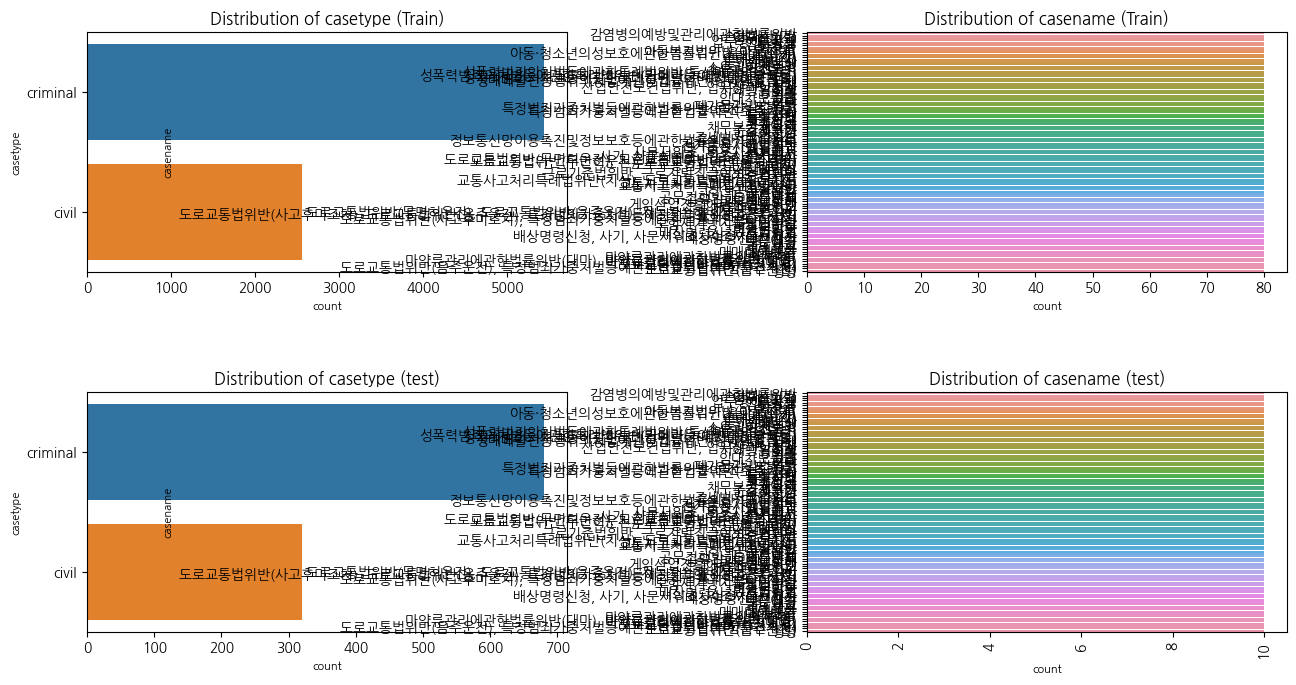

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10)) 
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.8, wspace=0.5, hspace=0.5)

# Train 데이터 casetype 분포
sns.countplot(y="casetype", data=train, order=train['casetype'].value_counts().index, ax=axes[0, 0])
axes[0, 0].set_xlabel('count', fontsize=8)
axes[0, 0].set_ylabel('casetype', fontsize=8)
axes[0, 0].set_title('Distribution of casetype (Train)')

# Train 데이터 casename 분포
sns.countplot(y="casename", data=train, order=train['casename'].value_counts().index, ax=axes[0, 1])
axes[0, 1].set_xlabel('count', fontsize=8)
axes[0, 1].set_ylabel('casename', fontsize=8)
axes[0, 1].set_title('Distribution of casename (Train)')

# test 데이터 casetype 분포
sns.countplot(y="casetype", data=test, order=test['casetype'].value_counts().index, ax=axes[1, 0])
axes[1, 0].set_xlabel('count', fontsize=8)
axes[1, 0].set_ylabel('casetype', fontsize=8)
axes[1, 0].set_title('Distribution of casetype (test)')

# test 데이터 casename 분포
sns.countplot(y="casename", data=test, order=test['casename'].value_counts().index, ax=axes[1, 1])
axes[1, 1].set_xlabel('count', fontsize=8)
axes[1, 1].set_ylabel('casename', fontsize=8)
axes[1, 1].set_title('Distribution of casename (test)')

plt.xticks(rotation=90)  # x축 글자 90도 회전
plt.show()


### len

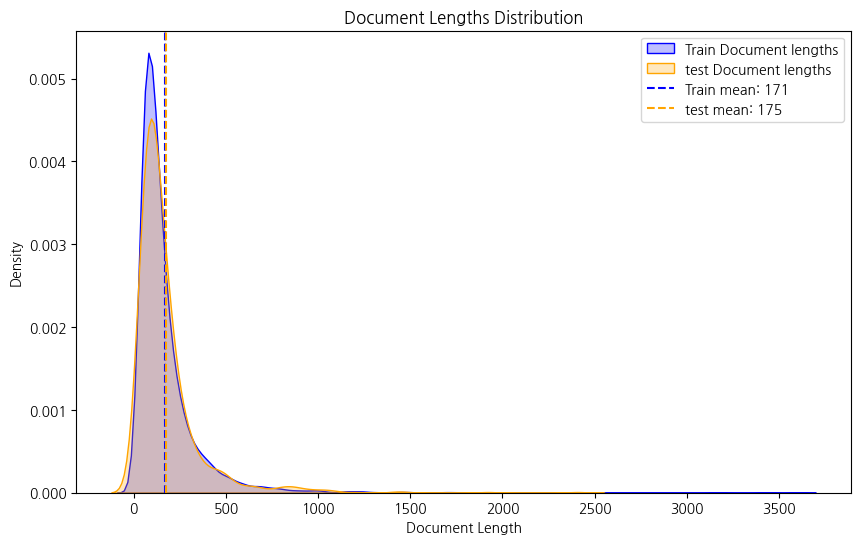

Train 데이터셋에서 가장 긴 문장: 3605개의 단어
Train 데이터셋에서 가장 짧은 문장: 4개의 단어
test 데이터셋에서 가장 긴 문장: 2408개의 단어
test 데이터셋에서 가장 짧은 문장: 24개의 단어


In [14]:
# train과 test 데이터셋의 'doc_len' 칼럼 생성
train['doc_len'] = train.facts.apply(lambda words: len(words.split()))
test['doc_len'] = test.facts.apply(lambda words: len(words.split()))

# plot
plt.figure(figsize=(10, 6))
sns.kdeplot(train['doc_len'], label='Train Document lengths', shade=True, color="blue")
sns.kdeplot(test['doc_len'], label='test Document lengths', shade=True, color="orange")
plt.axvline(x=train['doc_len'].mean(), color='blue', linestyle='--', label=f'Train mean: {train["doc_len"].mean():.0f}')
plt.axvline(x=test['doc_len'].mean(), color='orange', linestyle='--', label=f'test mean: {test["doc_len"].mean():.0f}')
plt.title("Document Lengths Distribution")
plt.xlabel("Document Length")
plt.ylabel("Density")
plt.legend()
plt.show()

# 가장 긴 문장과 가장 짧은 문장의 단어 수 출력
max_train_len = train['doc_len'].max()
min_train_len = train['doc_len'].min()
max_test_len = test['doc_len'].max()
min_test_len = test['doc_len'].min()

print(f"Train 데이터셋에서 가장 긴 문장: {max_train_len}개의 단어")
print(f"Train 데이터셋에서 가장 짧은 문장: {min_train_len}개의 단어")
print(f"test 데이터셋에서 가장 긴 문장: {max_test_len}개의 단어")
print(f"test 데이터셋에서 가장 짧은 문장: {min_test_len}개의 단어")

### WordCloud
토크나이저와 불용어 전처리를 모두 적용하지 않음

In [15]:
def base_wordcloud(data, text_column_name):
    # 모든 텍스트를 하나의 문자열로 결합
    text = " ".join(data[text_column_name].dropna().tolist())
    
    # 워드 클라우드 생성
    wordcloud = WordCloud(
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # 한글 폰트 경로
        width=800, 
        height=400, 
        background_color='white'
    ).generate(text)
    
    # 워드 클라우드 표시
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

train


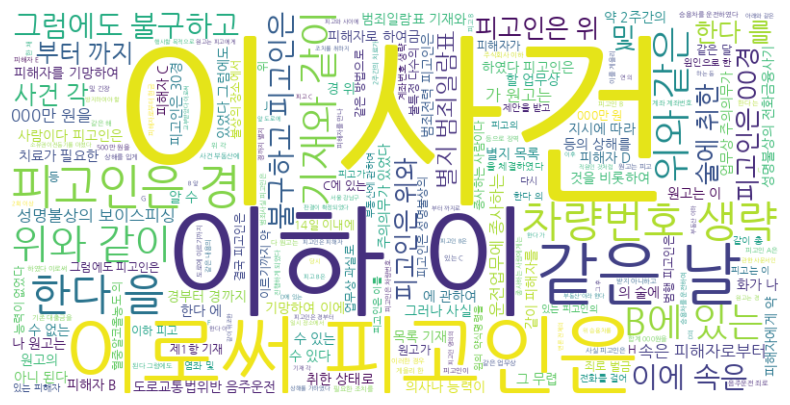

None
test


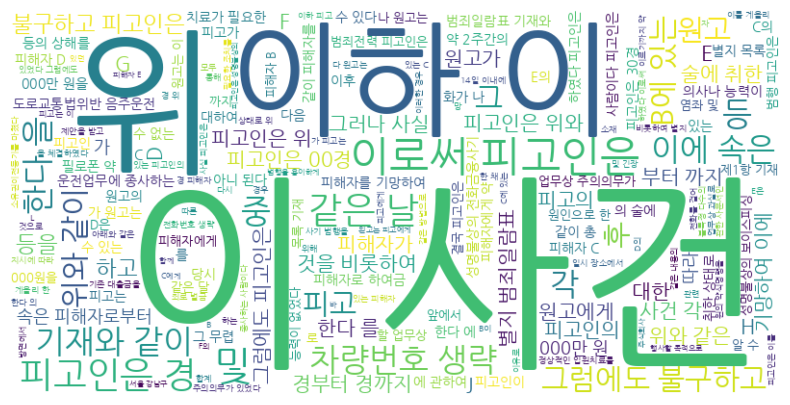

None


In [16]:
print('train')
print (base_wordcloud(train, 'facts'))

print('test')
print( base_wordcloud(test, 'facts'))

## 2. Load Model - Korea RoBERTa

In [23]:
# KLUE RoBERTa 모델과 토크나이저 설정
from transformers import AutoModel, AutoTokenizer

model_name = "klue/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModel.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Token indices sequence length is longer than the specified maximum sequence length for this model (1147 > 512). Running this sequence through the model will result in indexing errors


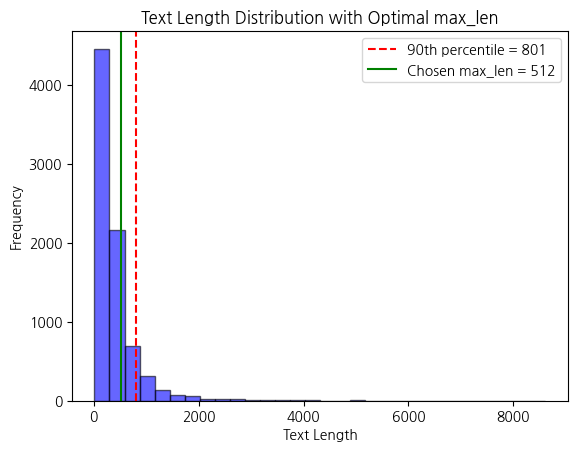

In [25]:
token_lengths = [len(tokenizer.encode(text)) for text in train["facts"]]

# 최적의 max_len 계산
max_len = calculate_optimal_max_len(token_lengths)

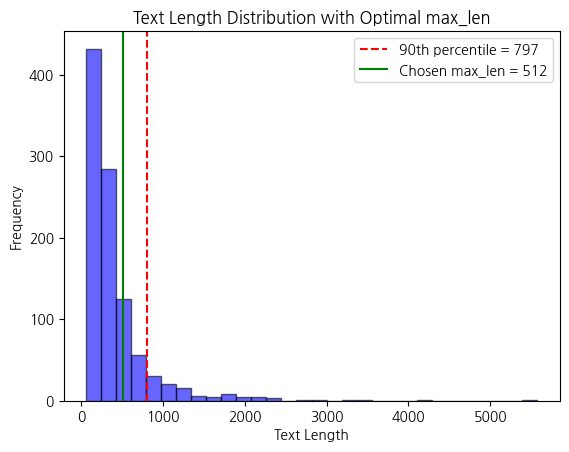

512

In [18]:
token_lengths = [len(tokenizer.encode(text)) for text in test["facts"]]

calculate_optimal_max_len(token_lengths)

## 3. visualization
- Apply Untrained AutoEncoder
- only for text column

In [19]:
# 임베딩 함수
def get_embedding(text, pbar=None):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_len).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # [CLS] 토큰의 임베딩을 사용
    embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    
    return embedding


# train과 test 데이터셋의 facts 컬럼 임베딩 생성 후 배열로 변환
train_embeddings = np.array([get_embedding(text) for text in train["facts"]])
test_embeddings = np.array([get_embedding(text) for text in test["facts"]])

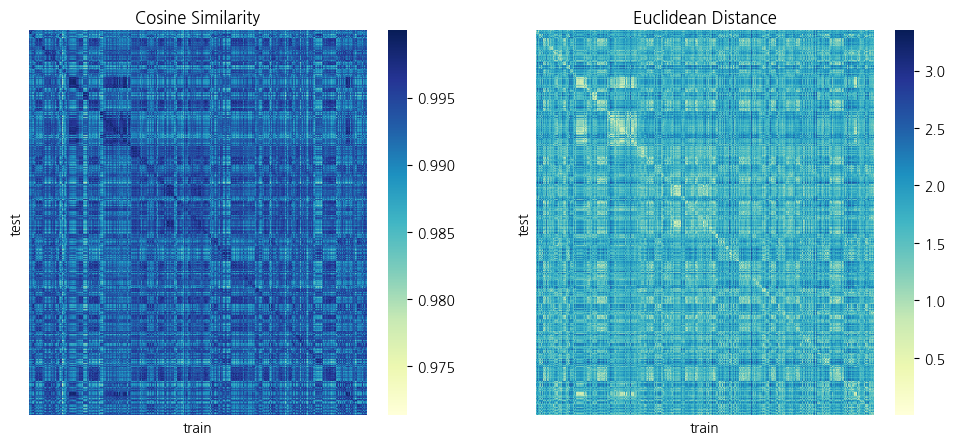

In [20]:
visualize_similarity_distance(train_embeddings, test_embeddings)

In [33]:
from alibi_detect.cd.pytorch import UAE

facts_list = train.facts.tolist()  # Series를 리스트로 변환

# Tokenize and get embeddings
all_embeddings = []
for i in range(0, len(facts_list), 32):
    batch_texts = facts_list[i:i + 32]
    tokens = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=128).to(device)
    
    with torch.no_grad():
        outputs = model(**tokens)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # CPU로 이동하여 Numpy 변환
    
    all_embeddings.append(batch_embeddings)

# 모든 배치 임베딩을 결합하여 최종 임베딩 배열 생성
embeddings = np.vstack(all_embeddings)

# Initialize UAE for dimensionality reduction
enc_dim = 32  # Target dimension for UAE
uae = UAE(input_layer=None, shape=(embeddings.shape[1],), enc_dim=enc_dim)  # input_layer=None으로 설정

# Apply UAE for dimensionality reduction
embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)  # Numpy 배열을 Torch Tensor로 변환
train_embeddings_uae = uae(embeddings_tensor).detach().cpu().numpy()

In [32]:
from alibi_detect.cd.pytorch import UAE

facts_list = test.facts.tolist()  # Series를 리스트로 변환

# Tokenize and get embeddings
all_embeddings = []
for i in range(0, len(facts_list), 32):
    batch_texts = facts_list[i:i + 32]
    tokens = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=128).to(device)
    
    with torch.no_grad():
        outputs = model(**tokens)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # CPU로 이동하여 Numpy 변환
    
    all_embeddings.append(batch_embeddings)

# 모든 배치 임베딩을 결합하여 최종 임베딩 배열 생성
embeddings = np.vstack(all_embeddings)

# Initialize UAE for dimensionality reduction
enc_dim = 32  # Target dimension for UAE
uae = UAE(input_layer=None, shape=(embeddings.shape[1],), enc_dim=enc_dim)  # input_layer=None으로 설정

# Apply UAE for dimensionality reduction
embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)  # Numpy 배열을 Torch Tensor로 변환
test_embeddings_uae = uae(embeddings_tensor).detach().cpu().numpy()

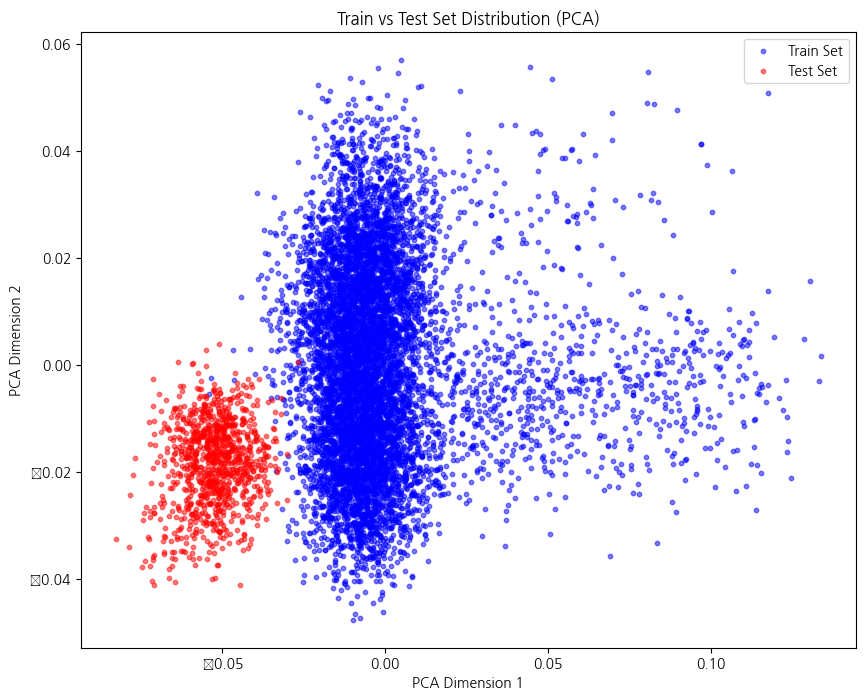

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA로 2D 차원 축소 수행
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings_uae)
test_pca = pca.transform(test_embeddings_uae)

# 시각화 (전체 데이터 사용)
plt.figure(figsize=(10, 8))
plt.scatter(train_pca[:, 0], train_pca[:, 1], color='blue', alpha=0.5, label='Train Set', s=10)
plt.scatter(test_pca[:, 0], test_pca[:, 1], color='red', alpha=0.5, label='Test Set', s=10)
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Train vs Test Set Distribution (PCA)')
plt.legend()
plt.show()

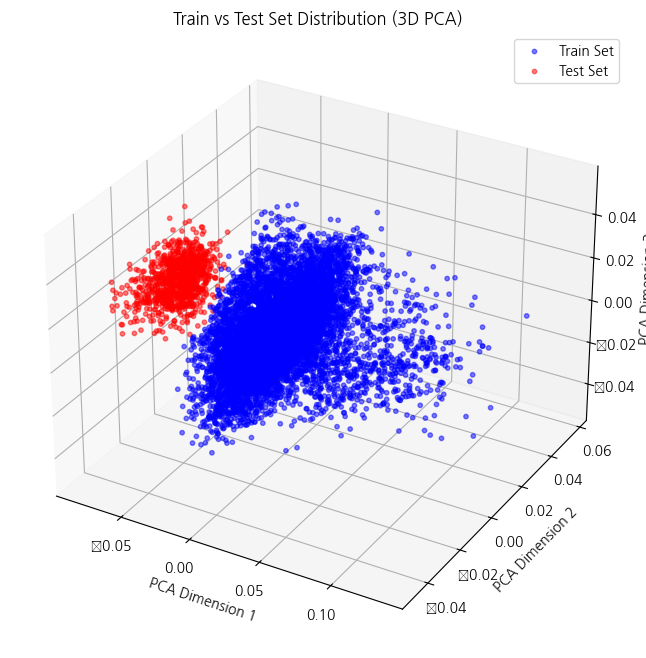

In [51]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# PCA로 3D 차원 축소 수행
pca = PCA(n_components=3)
train_pca = pca.fit_transform(train_embeddings_uae)
test_pca = pca.transform(test_embeddings_uae)

# 3D 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Train Set과 Test Set 시각화
ax.scatter(train_pca[:, 0], train_pca[:, 1], train_pca[:, 2], color='blue', alpha=0.5, label='Train Set', s=10)
ax.scatter(test_pca[:, 0], test_pca[:, 1], test_pca[:, 2], color='red', alpha=0.5, label='Test Set', s=10)

# 축과 제목 설정
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('PCA Dimension 3')
ax.set_title('Train vs Test Set Distribution (3D PCA)')
ax.legend()

plt.show()


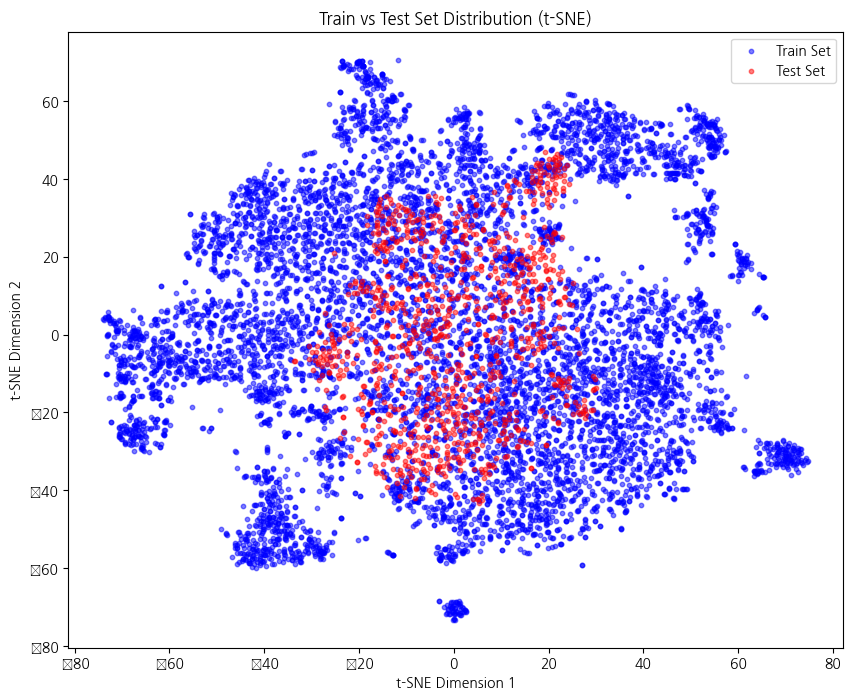

In [49]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE로 2D 차원 축소 수행
tsne = TSNE(n_components=2, random_state=42)
train_tsne = tsne.fit_transform(train_embeddings_uae)
test_tsne = tsne.fit_transform(test_embeddings_uae)

# 시각화 (t-SNE 결과 사용)
plt.figure(figsize=(10, 8))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], color='blue', alpha=0.5, label='Train Set', s=10)
plt.scatter(test_tsne[:, 0], test_tsne[:, 1], color='red', alpha=0.5, label='Test Set', s=10)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Train vs Test Set Distribution (t-SNE)')
plt.legend()
plt.show()

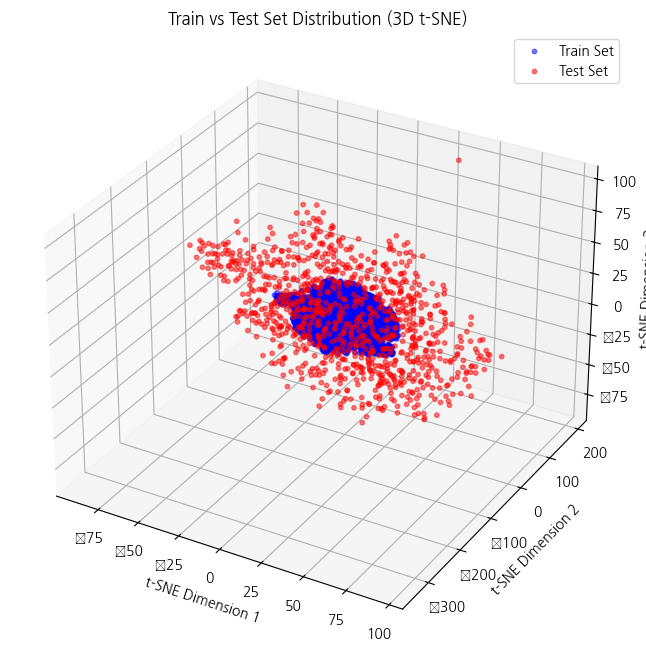

In [52]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# t-SNE로 3D 차원 축소 수행
tsne = TSNE(n_components=3, random_state=42)
train_tsne = tsne.fit_transform(train_embeddings_uae)
test_tsne = tsne.fit_transform(test_embeddings_uae)

# 3D 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Train Set과 Test Set 시각화
ax.scatter(train_tsne[:, 0], train_tsne[:, 1], train_tsne[:, 2], color='blue', alpha=0.5, label='Train Set', s=10)
ax.scatter(test_tsne[:, 0], test_tsne[:, 1], test_tsne[:, 2], color='red', alpha=0.5, label='Test Set', s=10)

# 축과 제목 설정
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
ax.set_title('Train vs Test Set Distribution (3D t-SNE)')
ax.legend()

plt.show()


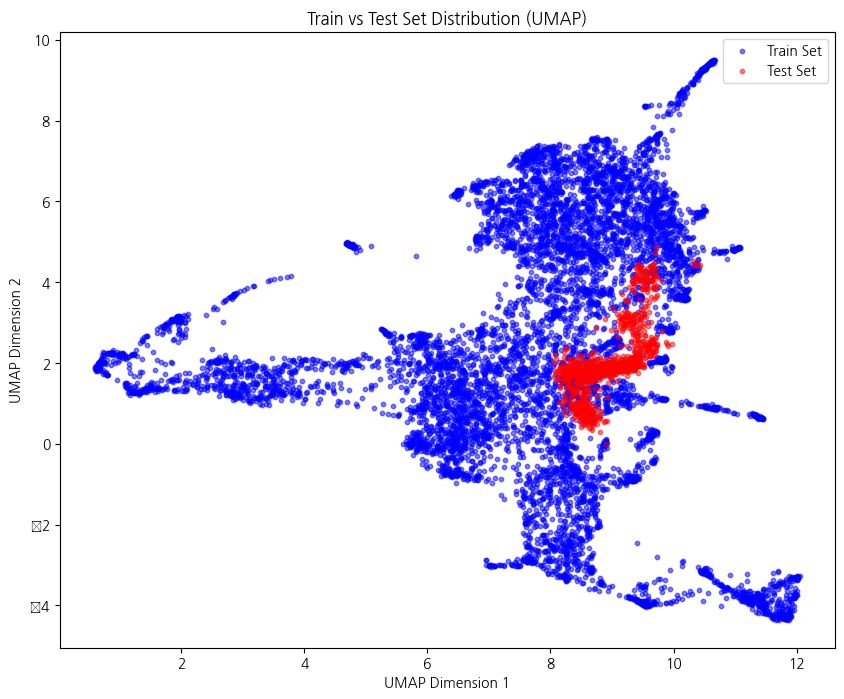

In [45]:
import umap.umap_ as umap  # UMAP을 불러오는 방식 수정

# UMAP으로 2D 차원 축소 수행
umap_reducer = umap.UMAP(n_components=2, random_state=42)
train_umap = umap_reducer.fit_transform(train_embeddings_uae)
test_umap = umap_reducer.transform(test_embeddings_uae)

# 시각화 (UMAP 결과 사용)
plt.figure(figsize=(10, 8))
plt.scatter(train_umap[:, 0], train_umap[:, 1], color='blue', alpha=0.5, label='Train Set', s=10)
plt.scatter(test_umap[:, 0], test_umap[:, 1], color='red', alpha=0.5, label='Test Set', s=10)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('Train vs Test Set Distribution (UMAP)')
plt.legend()
plt.show()

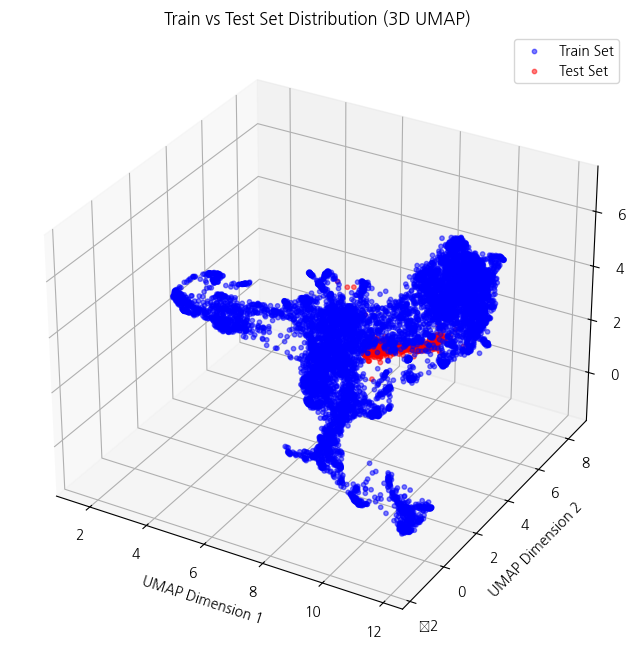

In [53]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# UMAP으로 3D 차원 축소 수행
umap_reducer = umap.UMAP(n_components=3, random_state=42)
train_umap = umap_reducer.fit_transform(train_embeddings_uae)
test_umap = umap_reducer.transform(test_embeddings_uae)

# 3D 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Train Set과 Test Set 시각화
ax.scatter(train_umap[:, 0], train_umap[:, 1], train_umap[:, 2], color='blue', alpha=0.5, label='Train Set', s=10)
ax.scatter(test_umap[:, 0], test_umap[:, 1], test_umap[:, 2], color='red', alpha=0.5, label='Test Set', s=10)

# 축과 제목 설정
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')
ax.set_title('Train vs Test Set Distribution (3D UMAP)')
ax.legend()

plt.show()


## 4. LSDD Drift 
> Least-Squares Density Difference 두 분포 간의 밀도 차이를 직접 최소 제곱법으로 추정

In [105]:
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from functools import partial

# CustomDataset 정의
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        facts = self.df.iloc[idx]['facts']
        meta = {
            'casetype': self.df.iloc[idx]['casetype'],
            'casename': self.df.iloc[idx]['casename']
        }
        return facts, meta

In [106]:
# 데이터셋 분할
train_idx, test_idx = train_test_split(np.arange(len(train)), 
                                       train_size=1 - len(test)/len(train),  # test 크기와 비율에 맞춤
                                       random_state=seed, 
                                       shuffle=True)

# Subset 생성
ds_ref = Subset(CustomDataset(train), train_idx)
ds_h0 = Subset(CustomDataset(train), test_idx)
ds_h1 = CustomDataset(test)  # test 전체 사용

# DataLoader 설정을 위한 partial 함수
data_loader = partial(DataLoader, shuffle=True, batch_size=100, num_workers=4)

# DataLoader 생성
dl_ref = data_loader(ds_ref)
dl_h0 = data_loader(ds_h0)
dl_h1 = data_loader(ds_h1)


In [107]:
from typing import List

'''
샘플 데이터를 추출해도 데이터 분포의 변화를 감지하는 데 충분히 유효한 결과를 얻을 수 있기 때문에 샘플링을 활용
'''

def update_flat_list(x: List[list]):
    return [item for sublist in x for item in sublist]

def accumulate_sample_no_target(dataloader: DataLoader, sample_size: int):
    batch_count = 0
    x_out, meta_out = [], []
    
    for x, meta in dataloader:
        n_batch = len(x)
        idx = min(sample_size - batch_count, n_batch)
        batch_count += n_batch

        x_out += [x[:idx]]
        
        # meta가 dict라고 가정하고 각 항목을 슬라이싱하여 추가
        meta_sliced = {key: value[:idx] if hasattr(value, '__getitem__') else value for key, value in meta.items()}
        meta_out.append(meta_sliced)

        if batch_count >= sample_size:
            break

    x_out = update_flat_list(x_out)
    return x_out, meta_out

In [108]:
from alibi_detect.cd import LSDDDrift
from alibi_detect.cd.pytorch import preprocess_drift
from alibi_detect.models.pytorch import TransformerEmbedding # 모델의 특정 레이어에서 나온 임베딩을 효과적으로 추출하기 위한 목적으로 설계
from transformers import AutoTokenizer

emb_type = 'hidden_state'  # 레이어 출력을 평균화해 문장 임베딩 생성
n_layers = 8
layers = [-_ for _ in range(1, n_layers + 1)]
max_len = max_len  # max length for the tokenizer

embedding = TransformerEmbedding(model_name, emb_type, layers).to(device).eval()
preprocess_fn = partial(preprocess_drift, model=embedding, tokenizer=tokenizer, max_len=max_len, batch_size=32)

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

In [110]:
# 예측 함수
labels = ['No!', 'Yes!']

def print_preds(preds: dict, preds_name: str) -> None:
    print(preds_name)
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print(f'p-value: {preds["data"]["p_val"]:.3f}')
    print('')

In [109]:
def make_predictions(ref_size: int, test_size: int, n_sample: int) -> None:
    """ 타겟 레이블 없이 드리프트 MMD 감지기를 생성하고 예측하는 함수 """
    for _ in range(n_sample):
        # 데이터 샘플링
        x_ref, meta_ref = accumulate_sample_no_target(dl_ref, ref_size)
        x_h0, meta_h0 = accumulate_sample_no_target(dl_h0, test_size)
        x_h1, meta_h1 = accumulate_sample_no_target(dl_h1, test_size)
        
        # 드리프트 감지기 초기화 및 실행
        dd = LSDDDrift(x_ref, backend='pytorch', p_val=.05, 
                      preprocess_fn=preprocess_fn, 
                      n_permutations=1000)
        preds_h0 = dd.predict(x_h0)
        preds_h1 = dd.predict(x_h1)
        
        print_preds(preds_h0, 'H0')
        print_preds(preds_h1, 'H1')


In [111]:
make_predictions(ref_size=1000, test_size=1000, # 샘플 크기 임시 지정
                 n_sample=5)

Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


H0
Drift? No!
p-value: 0.635

H1
Drift? No!
p-value: 0.721



Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


H0
Drift? No!
p-value: 0.301

H1
Drift? No!
p-value: 0.957



Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


H0
Drift? No!
p-value: 0.787

H1
Drift? No!
p-value: 0.947



Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


H0
Drift? No!
p-value: 0.705

H1
Drift? No!
p-value: 0.789



Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


H0
Drift? No!
p-value: 0.919

H1
Drift? No!
p-value: 0.841



## 5. MMD
> Maximum Mean Discrepancy
     두 분포의 평균 차이를 최대화하는 방식으로 분포 간의 차이를 측정

[Drift detection on Amazon reviews](https://docs.seldon.io/projects/alibi-detect/en/latest/examples/cd_text_amazon.html)
- amazon 리뷰 데이터셋을 이용해 개별 사용자 간 성능 격차 문제가 있으며 이를 해결해 다양한 리뷰어 그룹에서 일관된 성능을 보일 수 있도록 함
- dataset 
    - [wilds](https://wilds.stanford.edu/datasets/#amazon)
- methods
    - MMD  

In [78]:
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from functools import partial

# CustomDataset 정의
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        facts = self.df.iloc[idx]['facts']
        meta = {
            'casetype': self.df.iloc[idx]['casetype'],
            'casename': self.df.iloc[idx]['casename']
        }
        return facts, meta

In [79]:
# 데이터셋 분할
train_idx, test_idx = train_test_split(np.arange(len(train)), 
                                       train_size=1 - len(test)/len(train),  # test 크기와 비율에 맞춤
                                       random_state=seed, 
                                       shuffle=True)

# Subset 생성
ds_ref = Subset(CustomDataset(train), train_idx)
ds_h0 = Subset(CustomDataset(train), test_idx)
ds_h1 = CustomDataset(test)  # test 전체 사용

# DataLoader 설정을 위한 partial 함수
data_loader = partial(DataLoader, shuffle=True, batch_size=100, num_workers=4)

# DataLoader 생성
dl_ref = data_loader(ds_ref)
dl_h0 = data_loader(ds_h0)
dl_h1 = data_loader(ds_h1)


예제와 달리, 타겟 레이블 없이 단순히 두 데이터 세트의 분포 차이를 확인하려는 경우, 텍스트나 다른 피처의 임베딩만으로도 드리프트 감지를 진행

In [94]:
from typing import List

'''
샘플 데이터를 추출해도 데이터 분포의 변화를 감지하는 데 충분히 유효한 결과를 얻을 수 있기 때문에 샘플링을 활용
'''

def update_flat_list(x: List[list]):
    return [item for sublist in x for item in sublist]

def accumulate_sample_no_target(dataloader: DataLoader, sample_size: int):
    batch_count = 0
    x_out, meta_out = [], []
    
    for x, meta in dataloader:
        n_batch = len(x)
        idx = min(sample_size - batch_count, n_batch)
        batch_count += n_batch

        x_out += [x[:idx]]
        
        # meta가 dict라고 가정하고 각 항목을 슬라이싱하여 추가
        meta_sliced = {key: value[:idx] if hasattr(value, '__getitem__') else value for key, value in meta.items()}
        meta_out.append(meta_sliced)

        if batch_count >= sample_size:
            break

    x_out = update_flat_list(x_out)
    return x_out, meta_out

In [89]:
from alibi_detect.cd import MMDDrift
from alibi_detect.cd.pytorch import preprocess_drift
from alibi_detect.models.pytorch import TransformerEmbedding # 모델의 특정 레이어에서 나온 임베딩을 효과적으로 추출하기 위한 목적으로 설계
from transformers import AutoTokenizer

emb_type = 'hidden_state'  # 레이어 출력을 평균화해 문장 임베딩 생성
n_layers = 8
layers = [-_ for _ in range(1, n_layers + 1)]
max_len = max_len  # max length for the tokenizer

embedding = TransformerEmbedding(model_name, emb_type, layers).to(device).eval()
preprocess_fn = partial(preprocess_drift, model=embedding, tokenizer=tokenizer, max_len=max_len, batch_size=32)

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

이전 파일에서는 직접 embedding 함수를 구현했는데, 이번엔 alibi-detect에서 제공하는 클래스를 적용해서 진행

In [95]:
# 예측 함수
labels = ['No!', 'Yes!']

def print_preds(preds: dict, preds_name: str) -> None:
    print(preds_name)
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print(f'p-value: {preds["data"]["p_val"]:.3f}')
    print('')

In [103]:
def make_predictions(ref_size: int, test_size: int, n_sample: int) -> None:
    """ 타겟 레이블 없이 드리프트 MMD 감지기를 생성하고 예측하는 함수 """
    for _ in range(n_sample):
        # 데이터 샘플링
        x_ref, meta_ref = accumulate_sample_no_target(dl_ref, ref_size)
        x_h0, meta_h0 = accumulate_sample_no_target(dl_h0, test_size)
        x_h1, meta_h1 = accumulate_sample_no_target(dl_h1, test_size)
        
        # 드리프트 감지기 초기화 및 실행
        dd = MMDDrift(x_ref, backend='pytorch', p_val=.05, 
                      preprocess_fn=preprocess_fn, 
                      n_permutations=1000)
        preds_h0 = dd.predict(x_h0)
        preds_h1 = dd.predict(x_h1)
        
        print_preds(preds_h0, 'H0')
        print_preds(preds_h1, 'H1')


In [104]:
make_predictions(ref_size=1000, test_size=1000, # 샘플 크기 임시 지정
                 n_sample=5)

Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


H0
Drift? No!
p-value: 0.405

H1
Drift? No!
p-value: 0.995



Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


H0
Drift? No!
p-value: 0.378

H1
Drift? No!
p-value: 0.927



Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


H0
Drift? No!
p-value: 0.712

H1
Drift? No!
p-value: 0.998



Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


H0
Drift? No!
p-value: 0.688

H1
Drift? No!
p-value: 0.688



Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


H0
Drift? No!
p-value: 0.777

H1
Drift? No!
p-value: 0.996



## 6. KS Test

오토인코더 적용해 임베딩 벡터의 차원을 줄여 drift detection의 효율을 높임

In [95]:
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from functools import partial

# CustomDataset 정의
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        facts = self.df.iloc[idx]['facts']
        meta = {
            'casetype': self.df.iloc[idx]['casetype'],
            'casename': self.df.iloc[idx]['casename']
        }
        return facts, meta

In [96]:
# 데이터셋 분할
train_idx, valid_idx = train_test_split(np.arange(len(train)), 
                                       train_size=1 - len(test)/len(train),  # test 크기와 비율에 맞춤
                                       random_state=seed, 
                                       shuffle=True)

X_ref = list(train.facts.iloc[train_idx])
X_h0 = list(train.facts.iloc[test_idx])
X_h1 = list(test.facts)

In [105]:
from alibi_detect.cd.pytorch import preprocess_drift
from alibi_detect.models.pytorch import TransformerEmbedding # 모델의 특정 레이어에서 나온 임베딩을 효과적으로 추출하기 위한 목적으로 설계
from transformers import AutoTokenizer

emb_type = 'hidden_state'  # 레이어 출력을 평균화해 문장 임베딩 생성
n_layers = 8
layers = [-_ for _ in range(1, n_layers + 1)]
max_len = max_len  # max length for the tokenizer

embedding = TransformerEmbedding(model_name, emb_type, layers).to(device).eval()
preprocess_fn = partial(preprocess_drift, model=embedding, tokenizer=tokenizer, max_len=max_len, batch_size=32)
embedding

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

TransformerEmbedding(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): 

In [106]:
# 임베딩이 올바르게 생성되었는지 확인
sample_batch = next(iter(dl_ref))
facts_batch, meta_batch = sample_batch
emb_batch = preprocess_fn(facts_batch)
print(emb_batch.shape)  # 각 배치에 대해 100개의 샘플이 있으며 각 샘플은 768차원의 벡터로 임베딩

(100, 768)


In [107]:
from alibi_detect.cd.pytorch import UAE

# UAE 설정
input_layer = embedding  # embedding을 input_layer로 사용
shape = (emb_batch.shape[1],)  # 임베딩 차원
enc_dim = 32  # 원하는 축소 차원

# UAE 인스턴스 생성
uae = UAE(input_layer=input_layer, shape=shape[0], enc_dim=enc_dim).to(device)
uae

UAE(
  (encoder): _Encoder(
    (input_layer): TransformerEmbedding(
      (model): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(32000, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (output):

In [108]:
from alibi_detect.cd import KSDrift
from alibi_detect.saving import save_detector, load_detector
from functools import partial
from alibi_detect.cd.pytorch import preprocess_drift

# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=uae, tokenizer=tokenizer,
                        max_len=max_len, batch_size=32)

# 리스트로 변환
X_ref = list(train.facts.iloc[train_idx])

# initialize detector
cd = KSDrift(X_ref, p_val=.05, preprocess_fn=preprocess_fn, input_shape=(max_len,))

# we can also save/load an initialised detector
filepath = 'KStest_path'  # change to directory where detector is saved
save_detector(cd, filepath)
cd = load_detector(filepath)

In [109]:
# 임베딩이 올바르게 생성되었는지 확인
sample_batch = next(iter(dl_ref))
facts_batch, meta_batch = sample_batch
emb_batch = preprocess_fn(facts_batch)
print(emb_batch.shape)  # 각 배치에 대해 100개의 샘플이 있으며 각 샘플은 768차원의 벡터로 임베딩

(100, 32)


In [110]:
X_h0 = list(train.facts.iloc[test_idx])

preds_h0 = cd.predict(X_h0)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))
print('p-value: {}'.format(preds_h0['data']['p_val']))

Drift? No!
p-value: [0.43892884 0.16481473 0.76205975 0.22469008 0.71362185 0.38493857
 0.3405572  0.76205975 0.59292656 0.02371418 0.31969047 0.4771282
 0.82706755 0.1527513  0.35132372 0.06851086 0.8392266  0.9419033
 0.43892884 0.38493857 0.45782104 0.42047295 0.5510216  0.249371
 0.8510433  0.76882154 0.49021795 0.81459224 0.8451794  0.64974326
 0.6212552  0.14699046]


In [111]:
X_h1 = list(test.facts)

preds_h0 = cd.predict(X_h1)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))
print('p-value: {}'.format(preds_h0['data']['p_val']))

Drift? No!
p-value: [0.43892884 0.8018271  0.64261425 0.93440545 0.5648915  0.81459224
 0.70658183 0.5236434  0.39657432 0.5101589  0.8510433  0.41442114
 0.2327034  0.8018271  0.74840176 0.5236434  0.07975619 0.70658183
 0.9737949  0.9263884  0.1307507  0.8018271  0.46421182 0.22867025
 0.25367293 0.87354887 0.21688741 0.30959174 0.18773259 0.26690623
 0.70658183 0.8893477 ]
